# <center>Assignment 5.3</center><br><center>Create Optimal Hotel Recommandation</center>

<center><b>Shani Kumar</b> <br> Bellevue University <br> Week 5 – 5.3</center>


### Introduction:

All online travel agencies are scrambling to meet the Artificial Intelligence driven personalization standard set by Amazon and Netflix. In addition, the world of online travel has become a highly competitive space where brands try to capture our attention (and wallet) with recommending, comparing, matching, and sharing. For this assignment, we aim to create the optimal hotel recommendations for Expedia’s users that are searching for a hotel to book. For this assignment, you need to predict which “hotel cluster” the user is likely to book, given his (or her) search details. In doing so, you should be able to demonstrate your ability to use four different algorithms (of your choice). The data set can be found at [Kaggle: Expedia Hotel Recommendations](https://www.kaggle.com/c/expedia-hotel-recommendations/data). To get you started, I would suggest you use train.csv which captured the logs of user behavior and destinations.csv which contains information related to hotel reviews made by users. You are also required to write a one page summary of your approach in getting to your prediction methods. I expect you to use a combination of R and Python in your answer.

### Source Data

https://www.kaggle.com/c/expedia-hotel-recommendations/data

**train.csv** - contains training set

**test.csv** - contains test set

**destinations.csv** - hotel search latent attributes


In [43]:
import pandas as pd
import pandas_profiling as pp
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
from datetime import datetime
from sklearn import svm
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestRegressor

# configure display of graph
%matplotlib inline

#stop unnecessary warnings from printing to the screen
warnings.simplefilter('ignore')

### Load data into a dataframe

In [11]:
#load training data
trn = pd.read_csv('data/train.csv', nrows = 100000)

# load test data
tst = pd.read_csv('./data/test.csv', nrows=100000)

# load destination data
dst = pd.read_csv('data/destinations.csv', nrows=100000)

### Exploratory Data Analysis

In [3]:
# eda of training data
pp.ProfileReport(trn)

Number of variables,24
Number of observations,100000
Total Missing (%),1.5%
Total size in memory,18.3 MiB
Average record size in memory,192.0 B
Numeric,18
Categorical,3
Boolean,3
Date,0
Text (Unique),0
Rejected,0


### Observations based on exploratory analysis
* Channel count is increasing year over year. 
* no features are strongly correlated with the target variable (hotel_cluster). This suggests that a linear method would perform poorly.
* There are 100 different clusters in target variable (hotel_cluster).
* There are two distinct values for **is_booking**, 0 and 1; where 1 if a booking, 0 if a click.
* **is_mobile** is 1 if booked through mobile phone, 0 if not.
* **is_package** is 1 if booked as part of a package, 0 if not. 
* There are some date fields which will need some work to extract date, time, hour and weekday details.

### See if there is any skewness in target data class

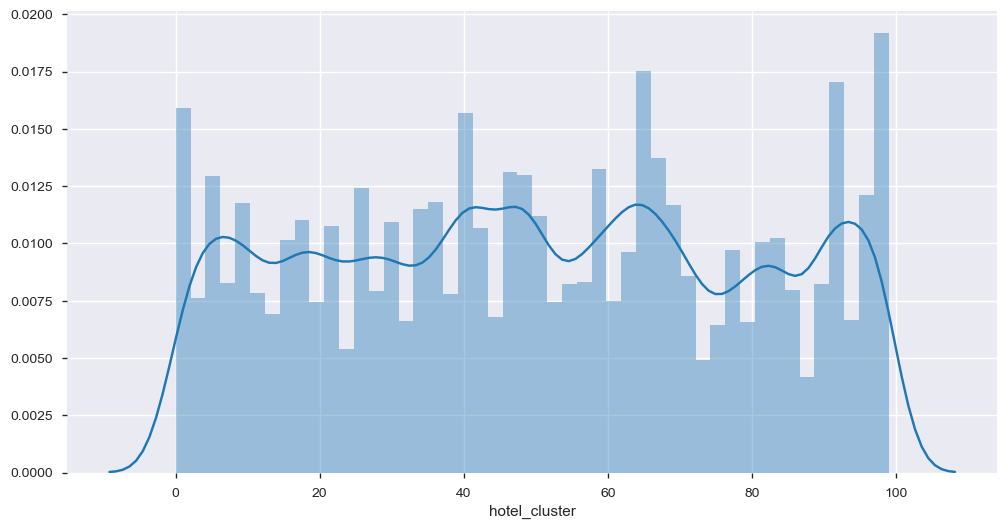

In [6]:
# histogram of clusters
plt.figure(figsize=(12, 6))
sns.distplot(trn['hotel_cluster'])

The data is pretty much well distributed over all 100 clusters and no skewness in the data.

### Extract Year and Montn details from date fields

The following date columns which needs some extra treatment

* **date_time** - Timestamp
* **srch_ci** - Checkin date
* **srch_co** - Checkout date

In [12]:
# Extract year part from a date

def fetch_year(x):
    '''
    Args:
        datetime
    Returns:
        year as numeric
    '''
    if x is not None and type(x) is not float:
        try:
            return datetime.strptime(x, '%Y-%m-%d').year
        except ValueError:
            return datetime.strptime(x, '%Y-%m-%d %H:%M:%S').year
    else:
        return 2013
    pass

# Extract month part from a date

def fetch_month(x):
    '''
    Args:
        datetime
    Returns:
        month as numeric
    '''    
    if x is not None and type(x) is not float:
        try:
            return datetime.strptime(x, '%Y-%m-%d').month
        except:
            return datetime.strptime(x, '%Y-%m-%d %H:%M:%S').month
    else:
        return 1
    pass

In [13]:
# extract year and month from date time column
trn['date_time_year'] = pd.Series(trn.date_time, index = trn.index)
trn['date_time_month'] = pd.Series(trn.date_time, index = trn.index)

trn.date_time_year = trn.date_time_year.apply(lambda x: fetch_year(x))
trn.date_time_month = trn.date_time_month.apply(lambda x: fetch_month(x))
del trn['date_time']

In [14]:
# extract year and month from check in date column
trn['srch_ci_year'] = pd.Series(trn.srch_ci, index = trn.index)
trn['srch_ci_month'] = pd.Series(trn.srch_ci, index = trn.index)

trn.srch_ci_year = trn.srch_ci_year.apply(lambda x: fetch_year(x))
trn.srch_ci_month = trn.srch_ci_month.apply(lambda x: fetch_month(x))
del trn['srch_ci']

In [15]:
# extract year and month from check out date column
trn['srch_co_year'] = pd.Series(trn.srch_co, index = trn.index)
trn['srch_co_month'] = pd.Series(trn.srch_co, index = trn.index)

trn.srch_co_year = trn.srch_co_year.apply(lambda x: fetch_year(x))
trn.srch_co_month = trn.srch_co_month.apply(lambda x: fetch_month(x))
del trn['srch_co']

,site_name,posa_continent,user_location_country,user_location_region,user_location_city,orig_destination_distance,user_id,is_mobile,is_package,channel,...,hotel_continent,hotel_country,hotel_market,hotel_cluster,date_time_year,date_time_month,srch_ci_year,srch_ci_month,srch_co_year,srch_co_month
0,2,3,66,348,48862,2234.2641,12,0,1,9,...,2,50,628,1,2014,8,2014,8,2014,8
1,2,3,66,348,48862,2234.2641,12,0,1,9,...,2,50,628,1,2014,8,2014,8,2014,9
2,2,3,66,348,48862,2234.2641,12,0,0,9,...,2,50,628,1,2014,8,2014,8,2014,9
3,2,3,66,442,35390,913.1932,93,0,0,3,...,2,50,1457,80,2014,8,2014,11,2014,11
4,2,3,66,442,35390,913.6259,93,0,0,3,...,2,50,1457,21,2014,8,2014,11,2014,11


In [16]:
# check the transformed data
trn.head()

,site_name,posa_continent,user_location_country,user_location_region,user_location_city,orig_destination_distance,user_id,is_mobile,is_package,channel,...,hotel_continent,hotel_country,hotel_market,hotel_cluster,date_time_year,date_time_month,srch_ci_year,srch_ci_month,srch_co_year,srch_co_month
0,2,3,66,348,48862,2234.2641,12,0,1,9,...,2,50,628,1,2014,8,2014,8,2014,8
1,2,3,66,348,48862,2234.2641,12,0,1,9,...,2,50,628,1,2014,8,2014,8,2014,9
2,2,3,66,348,48862,2234.2641,12,0,0,9,...,2,50,628,1,2014,8,2014,8,2014,9
3,2,3,66,442,35390,913.1932,93,0,0,3,...,2,50,1457,80,2014,8,2014,11,2014,11
4,2,3,66,442,35390,913.6259,93,0,0,3,...,2,50,1457,21,2014,8,2014,11,2014,11


## Modeling

For known combinations of user location cities, origin-destination distances and search destinations, will definitely help finding hotel cluster.


In [19]:
pieces = [trn.groupby(['srch_destination_id','hotel_country','hotel_market','hotel_cluster'])['is_booking'].agg(['sum','count'])]
agg = pd.concat(pieces).groupby(level=[0,1,2,3]).sum()
agg.dropna(inplace=True)

In [20]:
agg.head()

sum  count
srch_destination_id hotel_country hotel_market hotel_cluster            
8                   50            416          32               1      2
                                               60               0      1
                                               77               1      2
11                  50            824          94               1      2
14                  27            1434         20               1      3

In [21]:
agg['sum_and_cnt'] = 0.85*agg['sum'] + 0.15*agg['count']
agg = agg.groupby(level=[0,1,2]).apply(lambda x: x.astype(float)/x.sum())
agg.reset_index(inplace=True)

In [22]:
agg.head()

,srch_destination_id,hotel_country,hotel_market,hotel_cluster,sum,count,sum_and_cnt
0,8,50,416,32,0.5,0.4,0.469388
1,8,50,416,60,0.0,0.2,0.061224
2,8,50,416,77,0.5,0.4,0.469388
3,11,50,824,94,1.0,1.0,1.000000
4,14,27,1434,20,1.0,0.6,0.812500


In [23]:
agg_pivot = agg.pivot_table(index=['srch_destination_id','hotel_country','hotel_market'], 
                            columns='hotel_cluster', values='sum_and_cnt').reset_index()

In [24]:
agg_pivot.head()

hotel_cluster,srch_destination_id,hotel_country,hotel_market,0,1,2,3,4,5,6,...,90,91,92,93,94,95,96,97,98,99
0,8,50,416,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,11,50,824,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
2,14,27,1434,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,16,50,419,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,19,102,1522,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [27]:
trn = pd.merge(trn, dst, how='left', on='srch_destination_id')
trn = pd.merge(trn, agg_pivot, how='left', on=['srch_destination_id','hotel_country','hotel_market'])

In [18]:
trn_book = trn.loc[trn['is_booking'] == 1]

In [31]:
trn.fillna(0, inplace=True)
trn.shape

(100000, 276)

Create a pivot to map each cluster, and shape it accordingly so that it can be merged with the original data.

In [ ]:
# step 1
factors = [train_book.groupby(['srch_destination_id','hotel_country','hotel_market','is_package','hotel_cluster'])['is_booking'].agg(['sum','count'])]
summ = pd.concat(factors).groupby(level=[0,1,2,3,4]).sum()
summ.dropna(inplace=True)
summ.head()

In [ ]:
# step 2
summ['sum_and_cnt'] = 0.85*summ['sum'] + 0.15*summ['count']
summ = summ.groupby(level=[0,1,2,3]).apply(lambda x: x.astype(float)/x.sum())
summ.reset_index(inplace=True)
summ.head()

In [ ]:
# step 3
summ_pivot = summ.pivot_table(index=['srch_destination_id','hotel_country','hotel_market','is_package'], columns='hotel_cluster', values='sum_and_cnt').reset_index()
summ_pivot.head()

Quickly check the destination data to determine the relationship with other data.

In [ ]:
destination.head()

Merge the filtered booking data, pivotted data and destination data to form a single wide dataset.

In [ ]:
train_book = pd.merge(train_book, destination, how='left', on='srch_destination_id')
train_book = pd.merge(train_book, summ_pivot, how='left', on=['srch_destination_id','hotel_country','hotel_market','is_package'])
train_book.fillna(0, inplace=True)
train_book.shape

In [ ]:
train_book.head()

Since we are only interested in booking events, let us get rid of clicks.

In [33]:
trn = trn.loc[trn['is_booking'] == 1]

In [34]:
X = trn.drop(['user_id', 'hotel_cluster', 'is_booking'], axis=1)
y = trn.hotel_cluster
X.shape, y.shape

((8270, 273), (8270,))

Check if all of the 100 clusters are present in the training data.

In [35]:
y.nunique()

100

### 1. Support Vector Machine (SVM)

In [36]:
classifier = make_pipeline(preprocessing.StandardScaler(), svm.SVC(decision_function_shape='ovo'))
np.mean(cross_val_score(classifier, X, y, cv=10))

0.39911816734349126

### 2. Naive Bayes classifier

In [37]:
classifier = make_pipeline(preprocessing.StandardScaler(), GaussianNB(priors=None))
np.mean(cross_val_score(classifier, X, y, cv=10))

0.12789974331138057

### 3. Logistic Regression

In [38]:
classifier = make_pipeline(preprocessing.StandardScaler(), LogisticRegression(multi_class='ovr'))
np.mean(cross_val_score(classifier, X, y, cv=10))

0.35424495086296637

### 4. K-Nearest Neighbor classifier

In [39]:
classifier = make_pipeline(preprocessing.StandardScaler(), KNeighborsClassifier(n_neighbors=5))
np.mean(cross_val_score(classifier, X, y, cv=10, scoring='accuracy'))

0.33520784873335174

In [47]:
classifier = make_pipeline(preprocessing.StandardScaler(), 
                         RandomForestRegressor(n_estimators=100))
np.mean(cross_val_score(classifier, X, y, cv=10))

0.13409245219570218

In [40]:
%%html
<style>
table {float:left}
</style>

## Result Summary

 | Model         | Description | Results     |
| :---           |    :----   |          ---: |
| Support Vector Machine (SVM)            | Works well with large dataset and catagorical values  | 0.399   |
| Naive Bayes Classifier    | Simple and relatively Fast Model        | 0.127      |
| Logistic Regression  | Just to see performance with uncorrelated data   | 0.354      |
| KNN Classifier | Simple and relatively fast Model        | 0.335      |
| Random Forest  | Easy to tune but not good for last cluster with huge data        | 0.134      |


From my analysis SVM provided best result and Naive Bayes classifier performed worst.

Final numbers are low but this is because I did not do exdensive analysis and data cleanup and feature extraction and exclusion. Permforming more analysis work should increase the final result.

Also I can see scores are much lower than those on Kaggle, which is expected because we tried to fit our models without exploiting the data leak. On Kaggle, people were able predict ⅓ of the data 90% of the time just from using the data leak.

##  Summary

Here are the basis of the selection.

**1. Support Vector Machine (SVM)**
Support Vector Machines (SVMs) is good at finding pairwise interactions in data, so I through it should be good at recommending a hotel cluster to a certain user. Though natively, they don’t support multiclass classification, there are techniques we can use to it viably classify one out of 100 hotel clusters.

The benefit is that we can capture much more complex relationships between the datapoints without having to perform difficult transformations on our own. The downside is that the training time is much longer as it's much more computationally intensive.

It provided highest & best cross validation score.

**2. Naive Bayes classifier**
Naive Bayes is a relatively simple classifier that can natively be run on multiclass data, so I thought  at least try this type of classifier and see what kind of results we get initially.

But it has the worst performance of the four models. Therefore, this classifier is not recommended for the problem at hand.

**3. Logistic Regression**
We chose to test Logistic Regression because it was a simple model we learned in class that can handle non-linear decision boundaries, which we were clearly dealing with.

Logistic Regression was close to the performance of SVM but slightly worse.

**4. K-Nearest Neighbor classifier**
KNN was a good simple model to try because it ‘trains’ very quickly by offsetting most of the computation to the actual testing portion. Additionally it is relatively intuitive how the model works.

**5. Random Forest classifier**
One of the largest weakness of Random Forest Classifiers is large class imbalances. In addition with many classes, the decision trees become very deep and complex which goes against the marginal differences that RF averaging is going for. 

KNN performed very similar to Logistic Regression for the model in question but it was much faster than Logistic Regression
